<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Statsmodels.api" data-toc-modified-id="Statsmodels.api-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statsmodels.api</a></span></li><li><span><a href="#PyMC" data-toc-modified-id="PyMC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyMC</a></span><ul class="toc-item"><li><span><a href="#Approach-1:-Base-PyMC,-Gaussian-Random-Walk" data-toc-modified-id="Approach-1:-Base-PyMC,-Gaussian-Random-Walk-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Approach 1: Base PyMC, Gaussian Random Walk</a></span></li><li><span><a href="#PyMC-StateSpace-Implementation" data-toc-modified-id="PyMC-StateSpace-Implementation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PyMC StateSpace Implementation</a></span><ul class="toc-item"><li><span><a href="#Model" data-toc-modified-id="Model-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Priors" data-toc-modified-id="Priors-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Priors</a></span><ul class="toc-item"><li><span><a href="#Unconditional-Prior" data-toc-modified-id="Unconditional-Prior-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Unconditional Prior</a></span></li><li><span><a href="#Conditional-Prior" data-toc-modified-id="Conditional-Prior-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>Conditional Prior</a></span></li></ul></li><li><span><a href="#Posterior" data-toc-modified-id="Posterior-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Posterior</a></span><ul class="toc-item"><li><span><a href="#Conditional-Posterior" data-toc-modified-id="Conditional-Posterior-3.2.3.1"><span class="toc-item-num">3.2.3.1&nbsp;&nbsp;</span>Conditional Posterior</a></span></li><li><span><a href="#Unconditional-Posterior" data-toc-modified-id="Unconditional-Posterior-3.2.3.2"><span class="toc-item-num">3.2.3.2&nbsp;&nbsp;</span>Unconditional Posterior</a></span></li></ul></li></ul></li><li><span><a href="#Outputs-Compared" data-toc-modified-id="Outputs-Compared-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Outputs Compared</a></span></li><li><span><a href="#Smoother-Outputs-from-all-3-models" data-toc-modified-id="Smoother-Outputs-from-all-3-models-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Smoother Outputs from all 3 models</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
import sys

sys.path.append("..")

import jax

jax.config.update("jax_platform_name", "cpu")

import pymc as pm
import pytensor
from pytensor import tensor as pt

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, linalg

import time

config = {
    "figure.figsize": (12, 4),
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

# Data

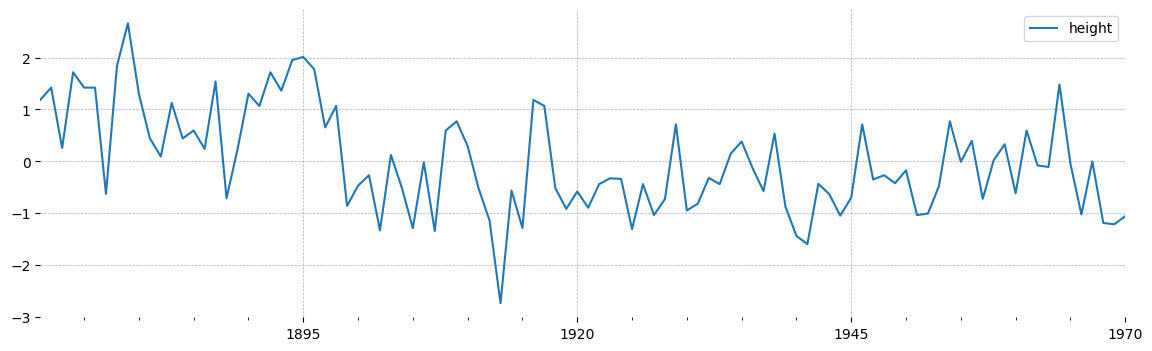

In [2]:
nile = pd.read_csv("../data/nile.csv")
nile.index = pd.date_range(start="1871-01-01", end="1970-01-01", freq="AS-Jan")
nile.rename(columns={"x": "height"}, inplace=True)

nile = (nile - nile.mean()) / nile.std()
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
nile.plot(ax=ax)
plt.show()

# Statsmodels.api 

In [3]:
nile_ml = sm.tsa.UnobservedComponents(nile, level="lltrend", initialization="approximate_diffuse")
res = nile_ml.fit(disp=0)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:             local linear trend   Log Likelihood                -127.011
Date:                Sat, 13 May 2023   AIC                            260.022
Time:                        20:15:15   BIC                            267.777
Sample:                    01-01-1871   HQIC                           263.159
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level         0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend      1.251e-11      0.000   8.51e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.30   Prob(JB):                         0.98
Heteroskedasticity (H):               0.62   Skew:                             0.05
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
ml_point_estimates = res.params.values

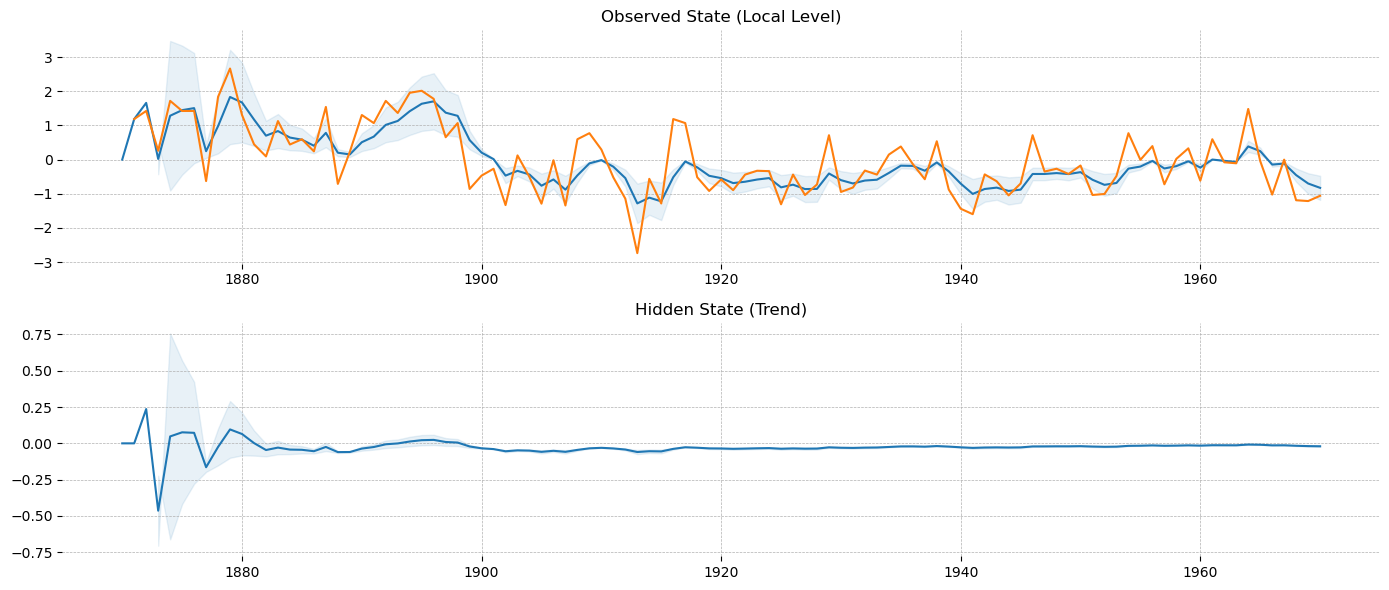

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=100)
x_values = nile.index
x_values_plus = pd.date_range(start="1870-01-01", end="1970-01-01", freq="AS-Jan")

state_mean = res.states.predicted.values
state_cov = res.states.predicted_cov.values.reshape(101, 2, 2)
ci_bounds = 1.96 * np.einsum("tk,tkj->tj", state_mean, state_cov)

upper = state_mean + ci_bounds
lower = state_mean - ci_bounds


ax[0].plot(x_values_plus, state_mean[:, 0])
ax[0].fill_between(x_values[2:], y1=lower[3:, 0], y2=upper[3:, 0], color="tab:blue", alpha=0.1)

ax[0].plot(x_values, nile.values)
ax[0].set(title="Observed State (Local Level)")

ax[1].plot(x_values_plus, state_mean[:, 1])
ax[1].fill_between(x_values[2:], y1=lower[3:, 1], y2=upper[3:, 1], color="tab:blue", alpha=0.1)

ax[1].set(title="Hidden State (Trend)")

fig.tight_layout()
plt.show()

# PyMC

## Approach 1: Base PyMC, Gaussian Random Walk

Thanks to @DanWeitzenfeld who showed me this implementation here: https://gist.github.com/DanielWeitzenfeld/1396dc9a1f4681dbff5e9d7fb19ccf25++. 

This is a very clean way to do a Local Level model, and it samples very fast.

In [6]:
coords = {"time": nile.index.year.values, "states": ["level", "trend"], "obs": ["nile"]}
n_obs = nile.shape[0]
with pm.Model() as model:

    sigma_mu = pm.HalfNormal("sigma_mu", sigma=1.0)
    mu = pm.Normal("mu", mu=0, sigma=sigma_mu, shape=n_obs).cumsum()

    sigma_obs = pm.HalfNormal("sigma_obs", 1.0)
    obs = pm.Normal("obs", mu=mu, sigma=sigma_obs, observed=nile.height)

    grw_trace = pm.sample(target_accept=0.95, nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.614929
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.653994
Transforming variables...
Transformation time =  0:00:00.017754


Estimated parameters are far from the Kalman filter estimates. I don't know why; need to think about the underlying math. It is missing the hidden trend state because it is folded into the GRW, which means some of the variance that is assigned to fluctuation in the trend state is instead put into the level state? 

There might be a direct equalivance between the two models that would allow us to recover parameter estimates for one from the other. Not sure.

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


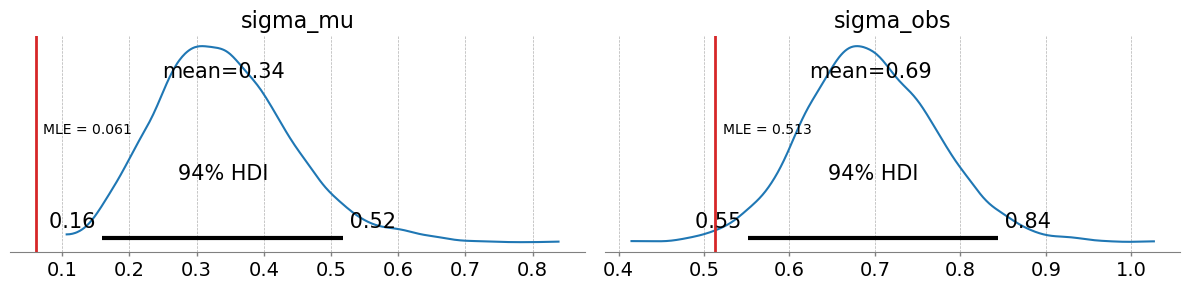

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3), dpi=100)
az.plot_posterior(grw_trace, var_names=["sigma_mu", "sigma_obs"], ax=ax)
params = ["sigma2.level", "sigma2.irregular"]
for axis, name in zip(fig.axes, params):
    axis.axvline(res.params[name], color="tab:red", lw=2)
    ymin, ymax = axis.get_ylim()
    midpoint = (ymax - ymin) / 2
    axis.annotate(xy=(res.params[name] + 0.01, midpoint), text=f"MLE = {res.params[name]:0.3f}")

fig.tight_layout()
plt.show()

In [8]:
with model:
    grw_post = pm.sample_posterior_predictive(grw_trace)

Sampling: [obs]


Note the ESS. The sampler has a hard time with this model, I assume because of the huge number of nusicance parameters (100 mus!). This likely only gets worse as you add additional hidden states. We can do better!

In [9]:
az.summary(grw_trace, var_names=["sigma_mu", "sigma_obs"])

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
sigma_mu   0.340  0.099   0.159    0.519      0.008    0.006     145.0  \
sigma_obs  0.694  0.078   0.551    0.845      0.004    0.003     447.0   

           ess_tail  r_hat  
sigma_mu      255.0   1.03  
sigma_obs    1222.0   1.01

In [10]:
grw_mu = grw_post["posterior_predictive"].obs.stack(idx=["chain", "draw"]).mean(axis=-1)
ci_05, ci_95 = (
    grw_post["posterior_predictive"]
    .obs.stack(idx=["chain", "draw"])
    .quantile([0.05, 0.95], dim="idx")
)

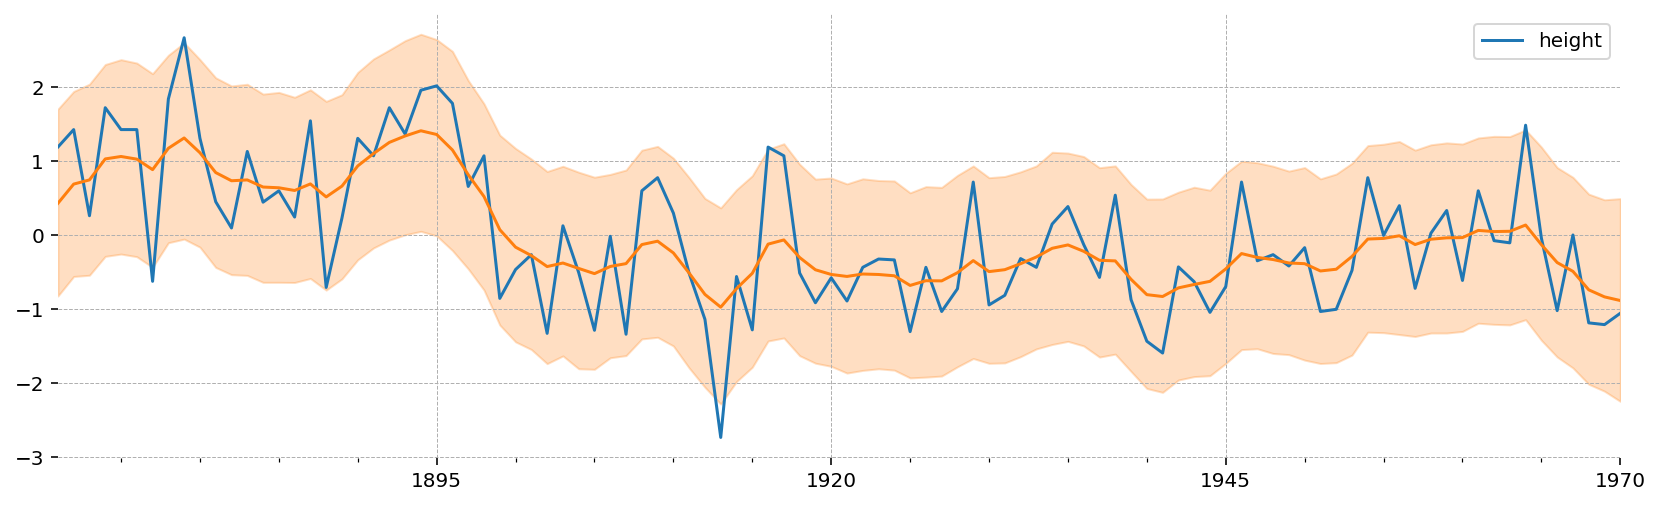

In [11]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
nile.plot(ax=ax)
pd.Series(grw_mu.values.ravel(), index=nile.index).plot(ax=ax)
ax.fill_between(x=nile.index, y1=ci_05, y2=ci_95, color="tab:orange", alpha=0.25)
plt.show()

## PyMC StateSpace Implementation

In [12]:
import pymc_experimental.statespace as pmss

state_space_model = pmss.BayesianLocalLevel(data=nile.values)

### Model

In [13]:
coords = {"time": nile.index.year.values, "states": ["level", "trend"], "obs": ["nile"]}

with pm.Model(coords=coords) as nile_model:
    state_sigmas = pm.HalfNormal("sigma_state", sigma=1.0, dims=["states"])
    obs_sigma = pm.HalfNormal("sigma_obs", sigma=1.0)

    sigma_P0 = pm.InverseGamma("P0_diag", mu=1.0, sigma=10.0, dims=["states"])
    x0 = pm.Normal("x0", mu=0.0, sigma=1.0, dims=["states"])

    P0 = pm.Deterministic("P0", pt.diag(sigma_P0))
    state_space_model.build_statespace_graph(mode="JAX")

    # If we also want smoother output, we have to ask for it. This is because it adds another scan
    # to the graph. It's not a problem for JAX, though!
    state_space_model.build_smoother_graph(mode="JAX")

### Priors

Like in the case of GPs, we can consider both an unconditional and a conditional output distribution. Helper functions in the PyMC Statespace `model` class help the user sample and plot one or the other.

#### Unconditional Prior

In [27]:
with nile_model:
    prior_simulated_states, _ = state_space_model.sample_unconditional_prior(
        n_steps=100, n_simulations=10, prior_samples=500
    )

Sampling: [P0_diag, sigma_obs, sigma_state, x0]


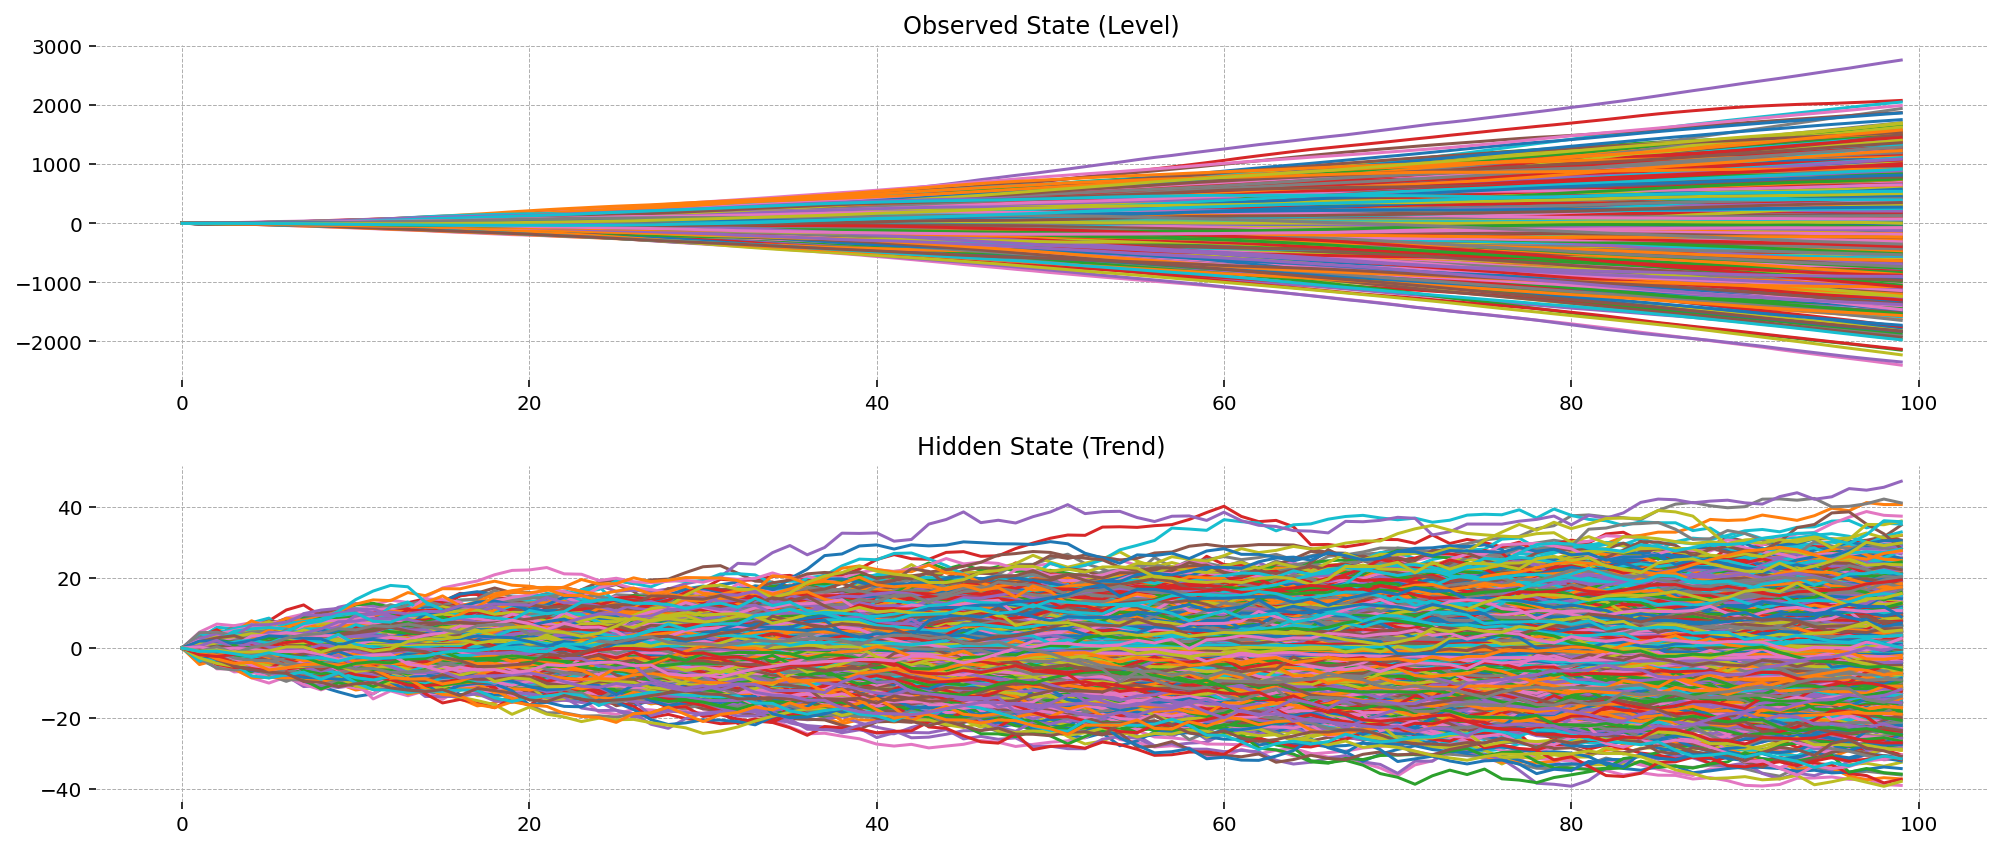

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(prior_simulated_states[:, :, idx].T)
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

#### Conditional Prior

The fit looks better than it is because the wide confidence intervals crush the means together. Up to +/- 4 standard deviations of variance of the trend is crazy 

Sampling: [P0_diag, sigma_obs, sigma_state, x0]


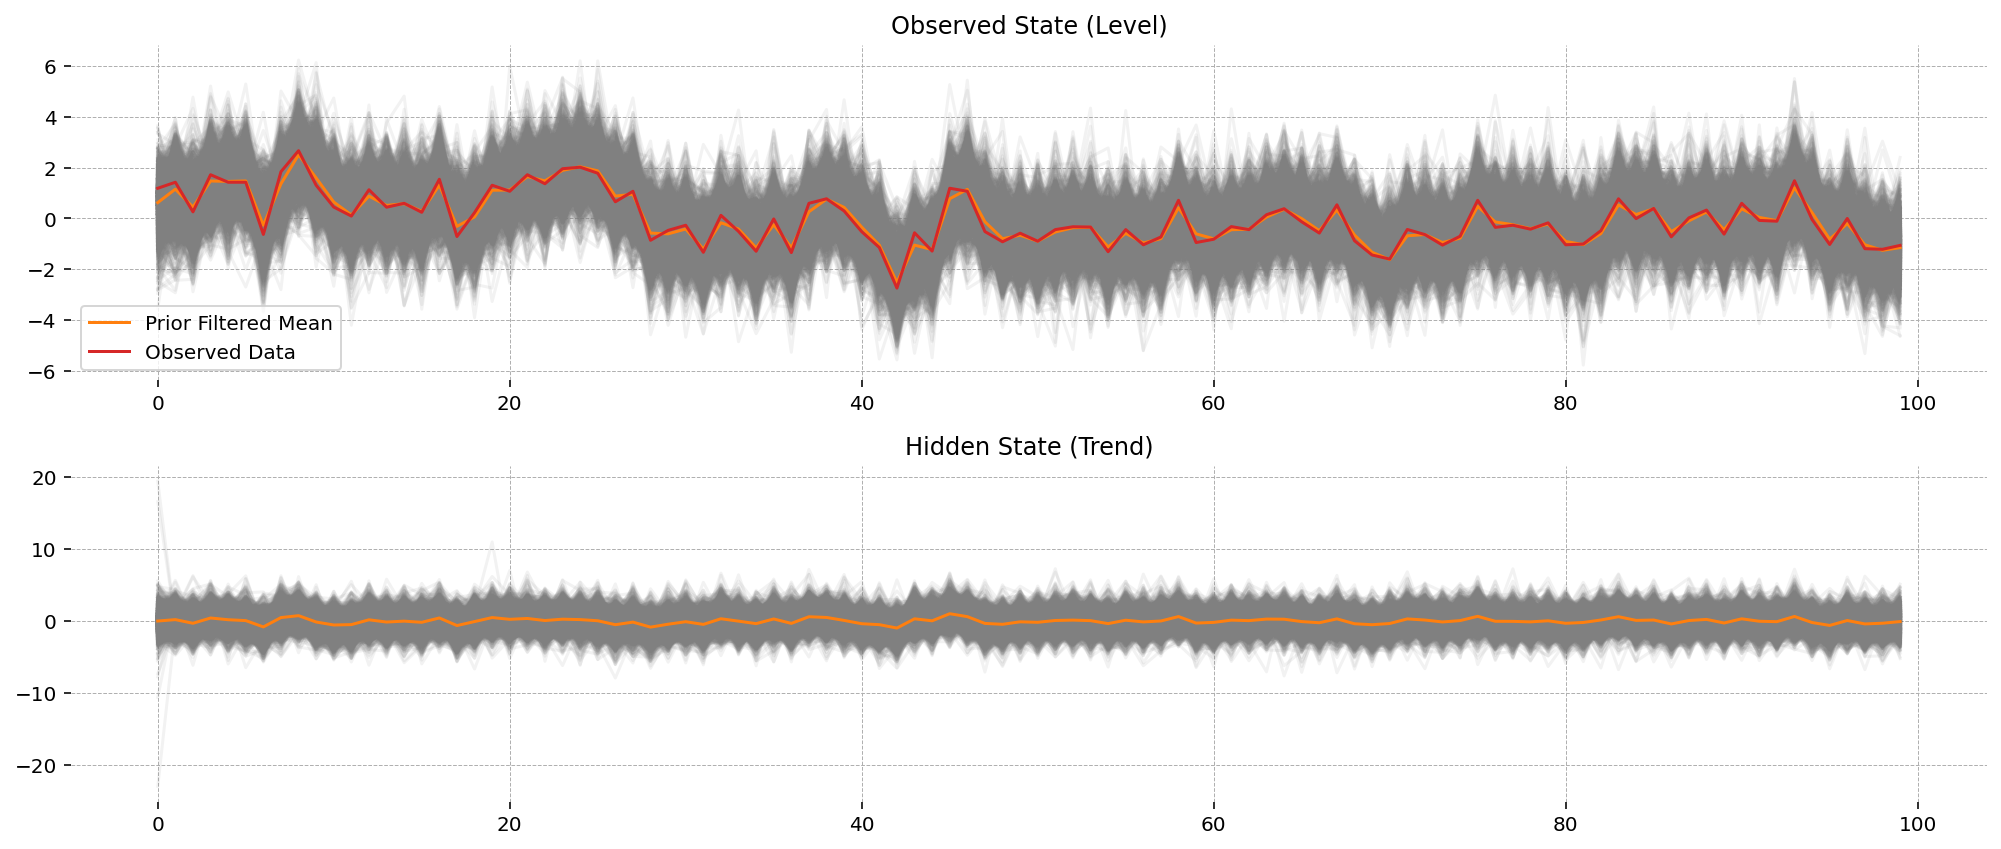

In [29]:
with nile_model:
    conditional_prior = state_space_model.sample_conditional_prior(
        n_simulations=10, filter_output="filtered"
    )

fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(conditional_prior[:, :, idx].T, color="0.5", alpha=0.1)
    axis.plot(
        conditional_prior[:, :, idx].mean(axis=0),
        color="tab:orange",
        label="Prior Filtered Mean",
    )
    if idx == 0:
        axis.plot(nile.values, color="tab:red", label="Observed Data")
    axis.set(title=name)

ax[0].legend(loc="lower left")
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

We need `pinv` for the Kalman smoother, but this doesn't have a jax overload by default yet. This code is just a hack to add it in.

In [29]:
import jax.numpy as jnp

from pytensor.tensor.nlinalg import MatrixPinv
from pytensor.link.jax.dispatch import jax_funcify


@jax_funcify.register(MatrixPinv)
def jax_funcify_Pinv(op, **kwargs):
    def pinv(x):
        return jnp.linalg.pinv(x)

    return pinv

In [30]:
with nile_model:
    kalman_trace = pm.sample(nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.898549
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:16.149813
Transforming variables...
Transformation time =  0:00:04.483792


### Posterior

In [31]:
az.summary(kalman_trace, var_names=["x0", "sigma_state", "sigma_obs", "P0_diag"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
x0[level]           0.640  0.711  -0.638    2.002      0.011    0.008  \
x0[trend]          -0.013  0.618  -1.216    1.088      0.009    0.010   
sigma_state[level]  0.135  0.095   0.000    0.291      0.002    0.002   
sigma_state[trend]  0.001  0.002   0.000    0.005      0.000    0.000   
sigma_obs           0.476  0.112   0.276    0.693      0.002    0.001   
P0_diag[level]      0.889  1.091   0.097    2.295      0.023    0.017   
P0_diag[trend]      0.872  1.426   0.108    2.132      0.034    0.024   

                    ess_bulk  ess_tail  r_hat  
x0[level]             4819.0    2534.0    1.0  
x0[trend]             4575.0    2654.0    1.0  
sigma_state[level]    2932.0    1665.0    1.0  
sigma_state[trend]    3865.0    2319.0    1.0  
sigma_obs             3053.0    2489.0    1.0  
P0_diag[level]        3852.0    2248.0    1.0  
P0_diag[trend]        2943.0    2174.0    1.0

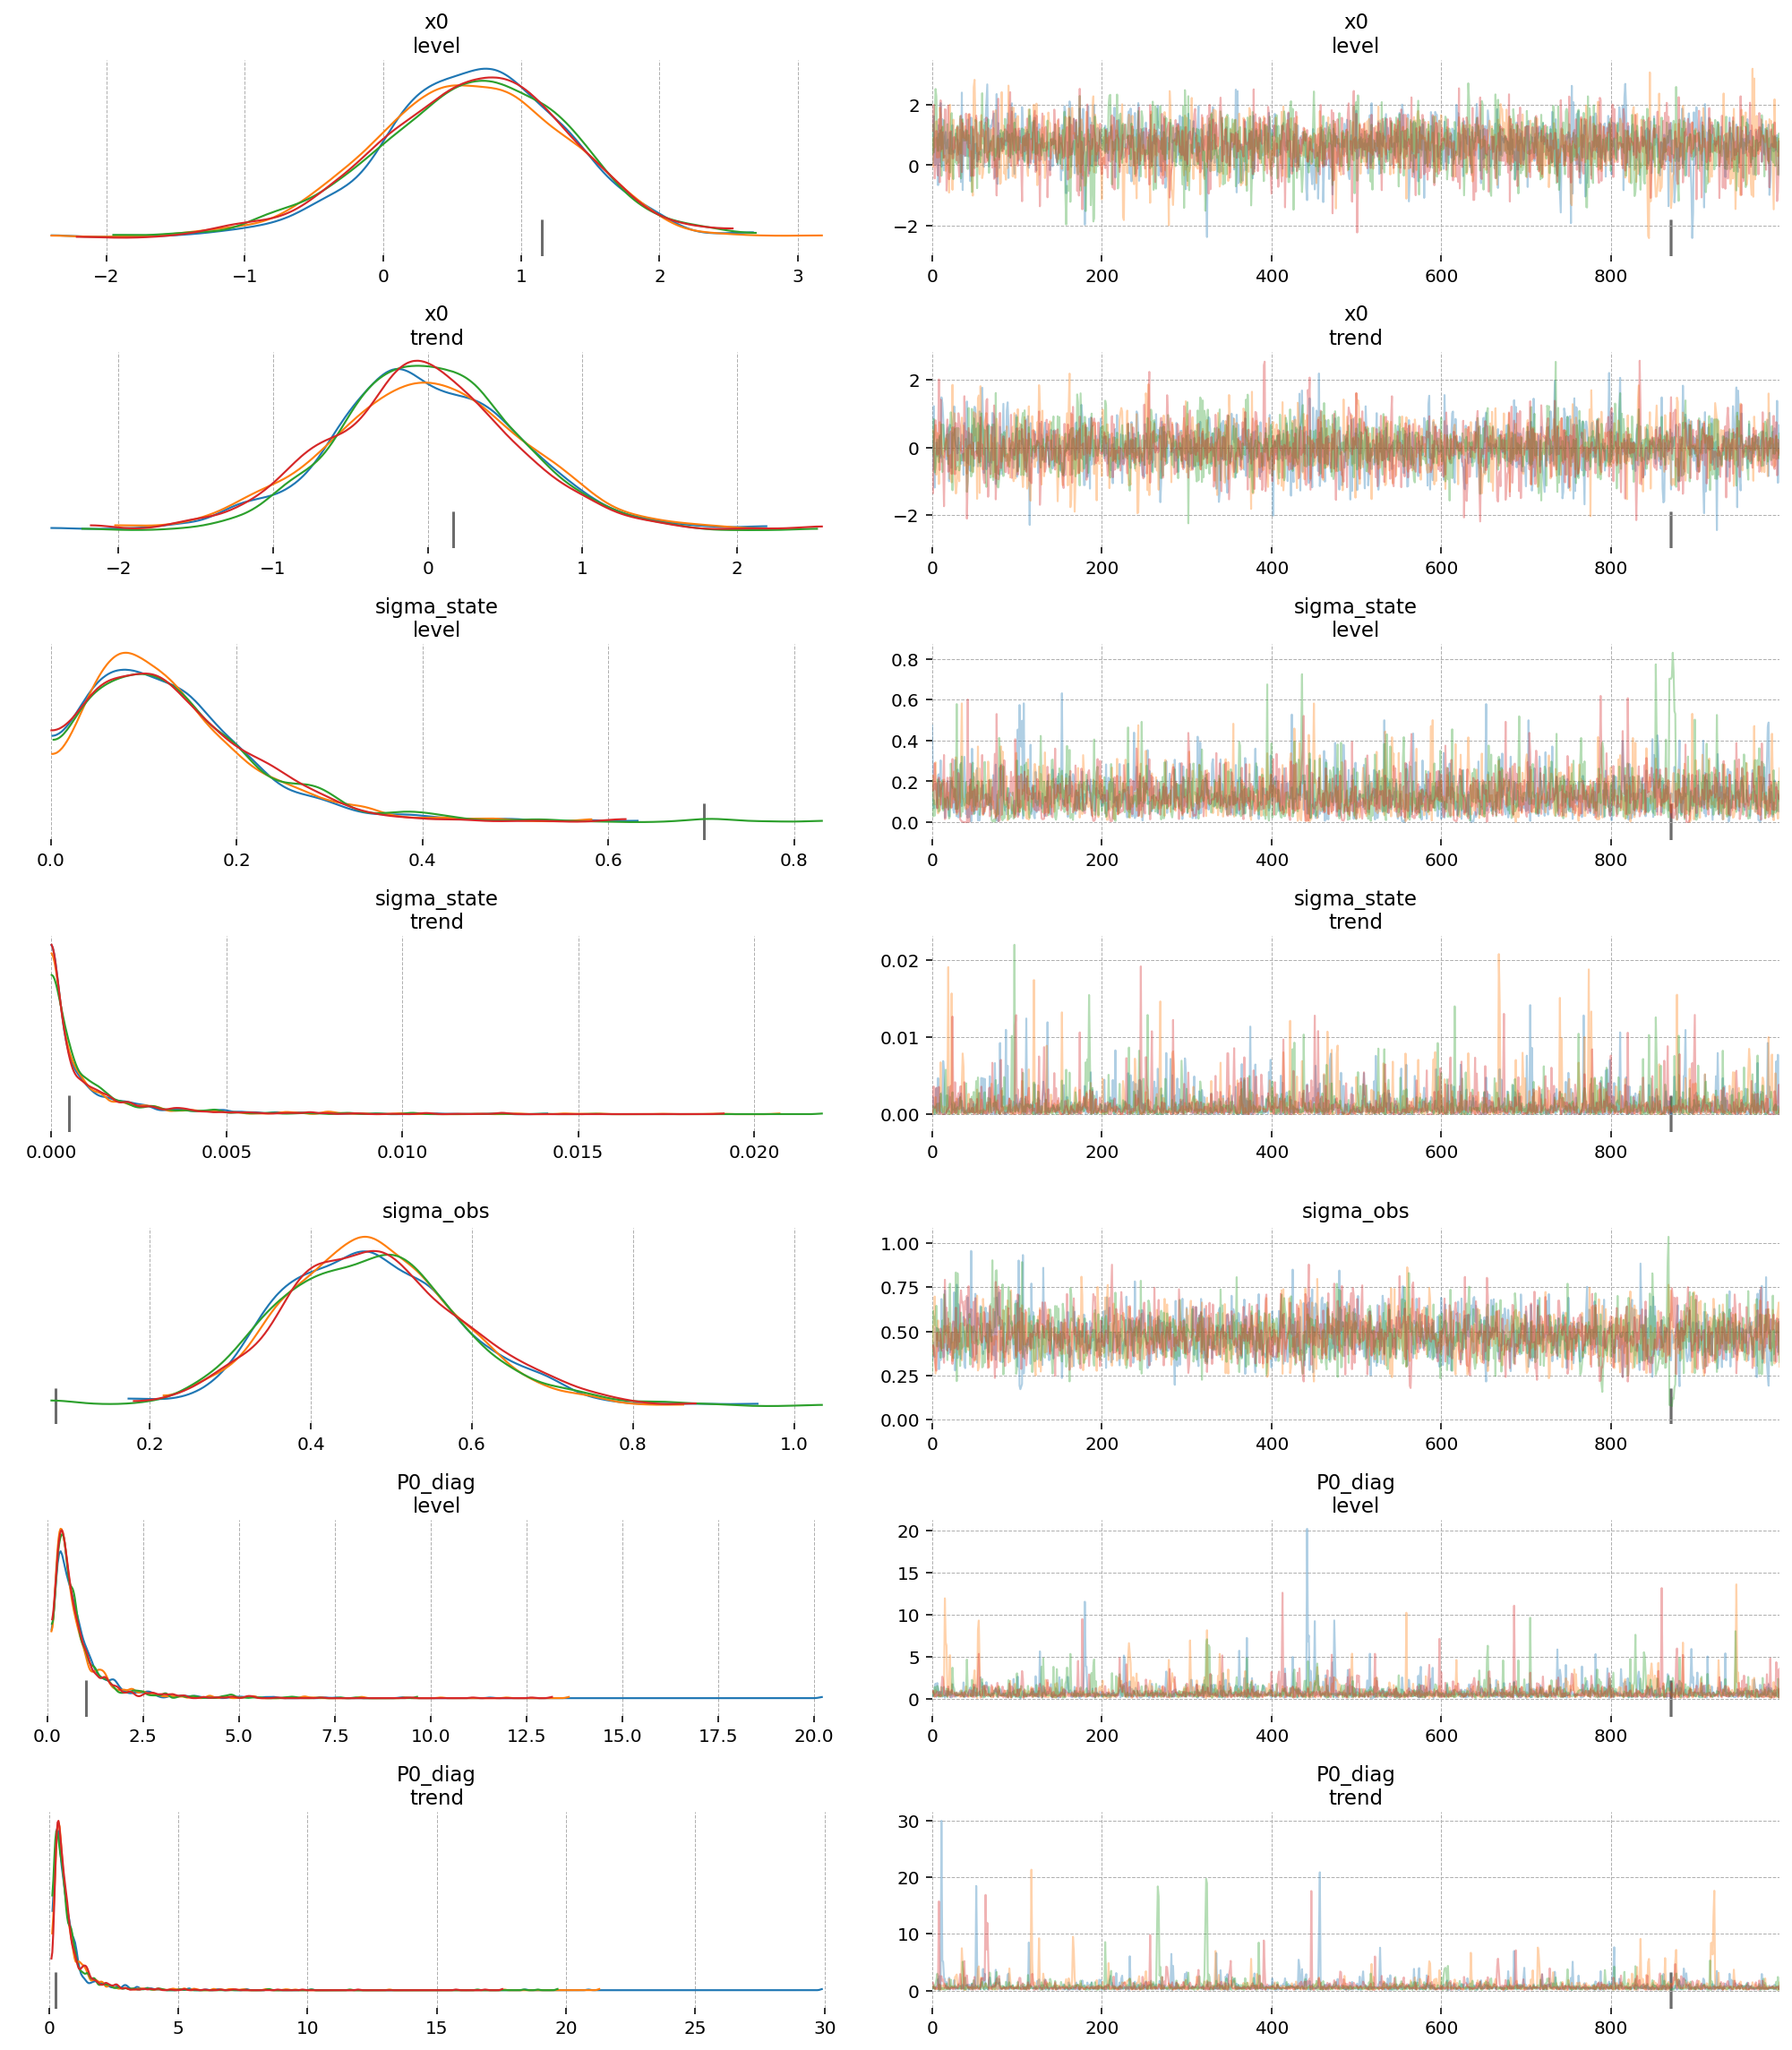

In [32]:
fig, ax = plt.subplots(7, 2, figsize=(14, 16), dpi=144)
az.plot_trace(
    kalman_trace,
    var_names=["x0", "sigma_state", "sigma_obs", "P0_diag"],
    compact=False,
    axes=ax,
)
fig.tight_layout()
plt.show()

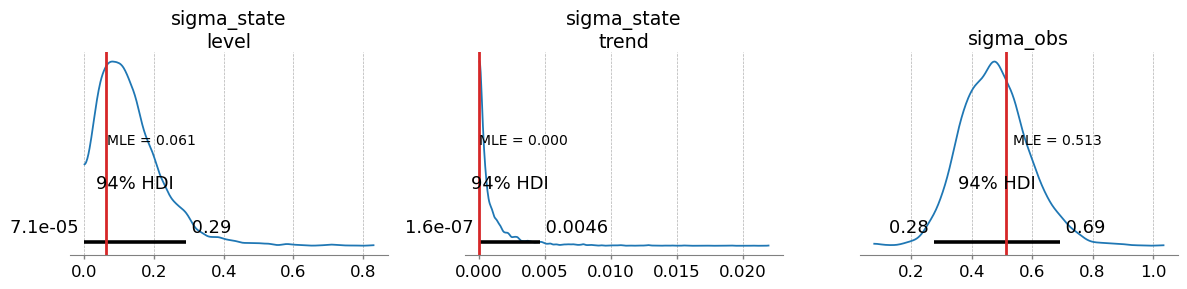

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
az.plot_posterior(
    kalman_trace,
    var_names=["sigma_state", "sigma_obs"],
    ax=ax,
    textsize=12,
    point_estimate=None,
)
params = ["sigma2.level", "sigma2.trend", "sigma2.irregular"]

for axis, name in zip(fig.axes, params):
    axis.axvline(res.params[name], color="tab:red", lw=2)
    ymin, ymax = axis.get_ylim()
    midpoint = (ymax - ymin) / 2
    axis.annotate(xy=(res.params[name] * 1.05, midpoint), text=f"MLE = {res.params[name]:0.3f}")

fig.set(facecolor="white")
fig.tight_layout()
plt.show()

#### Conditional Posterior

##### Filtered States

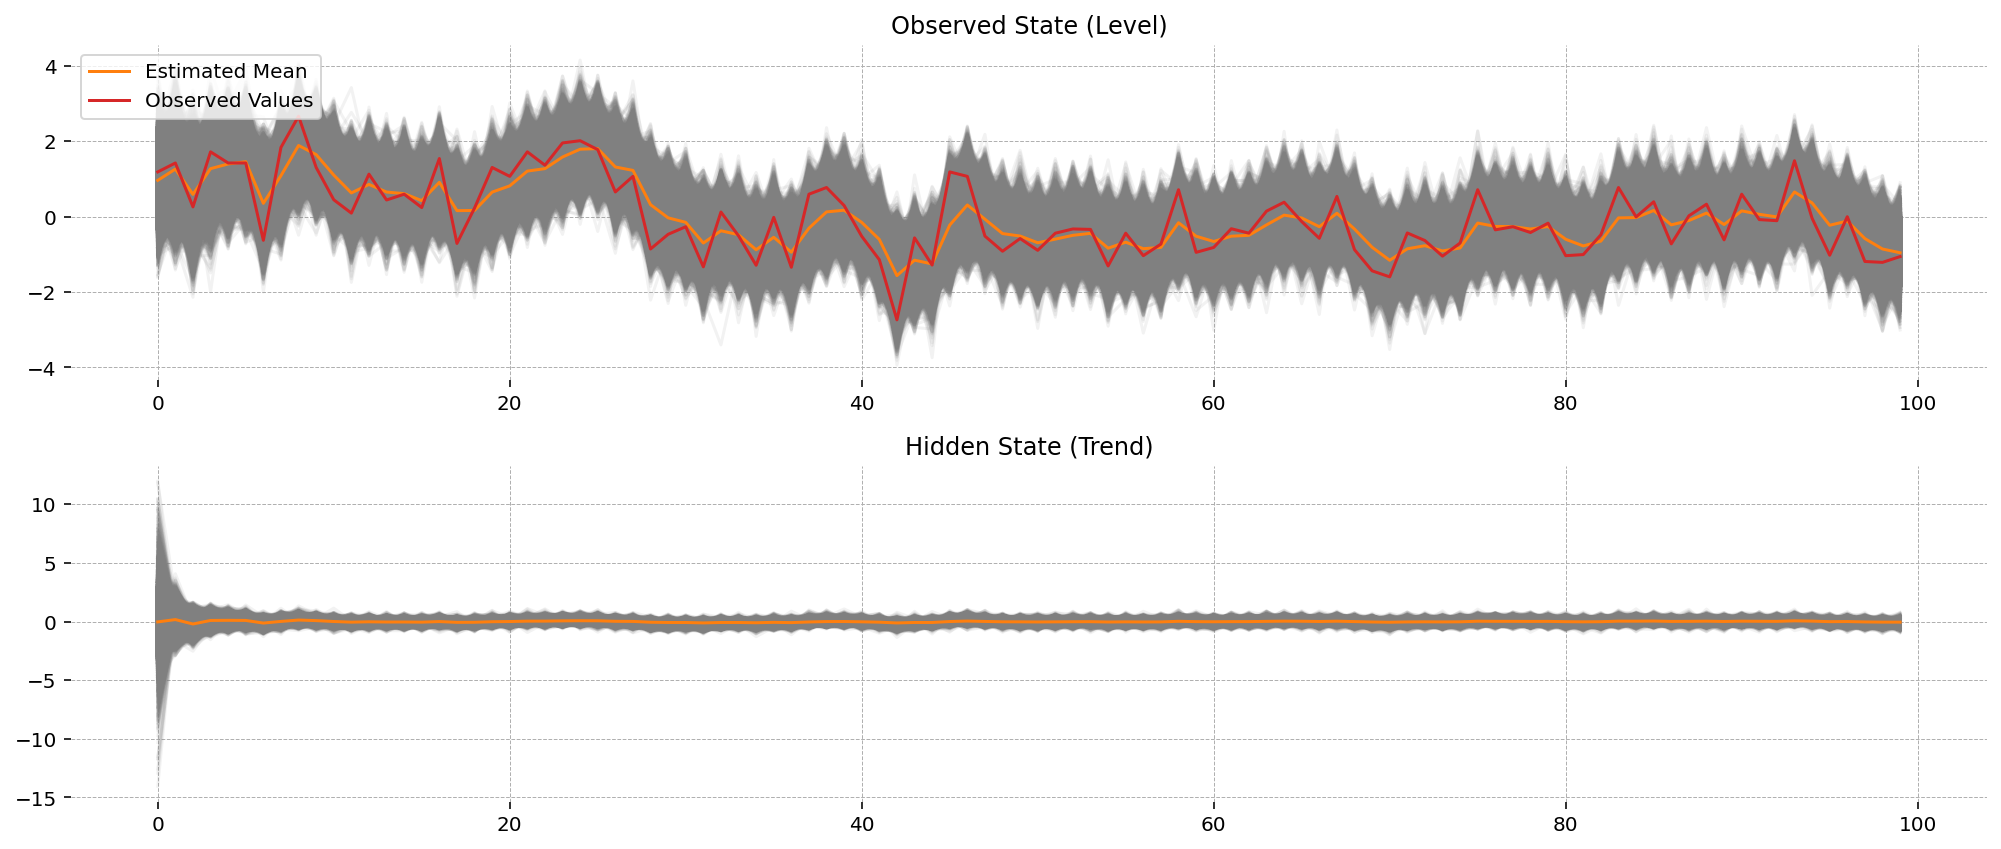

In [34]:
conditional_posterior = state_space_model.sample_conditional_posterior(
    kalman_trace, filter_output="filtered", posterior_samples=0.25
)

fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(conditional_posterior[:, :, idx].T, color="0.5", alpha=0.1)
    axis.plot(
        conditional_posterior[:, :, idx].mean(axis=0),
        color="tab:orange",
        label="Estimated Mean",
    )
    if idx == 0:
        axis.plot(nile.values, color="tab:red", label="Observed Values")
    axis.set(title=name)

ax[0].legend(loc="upper left")
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

##### Smoothed States

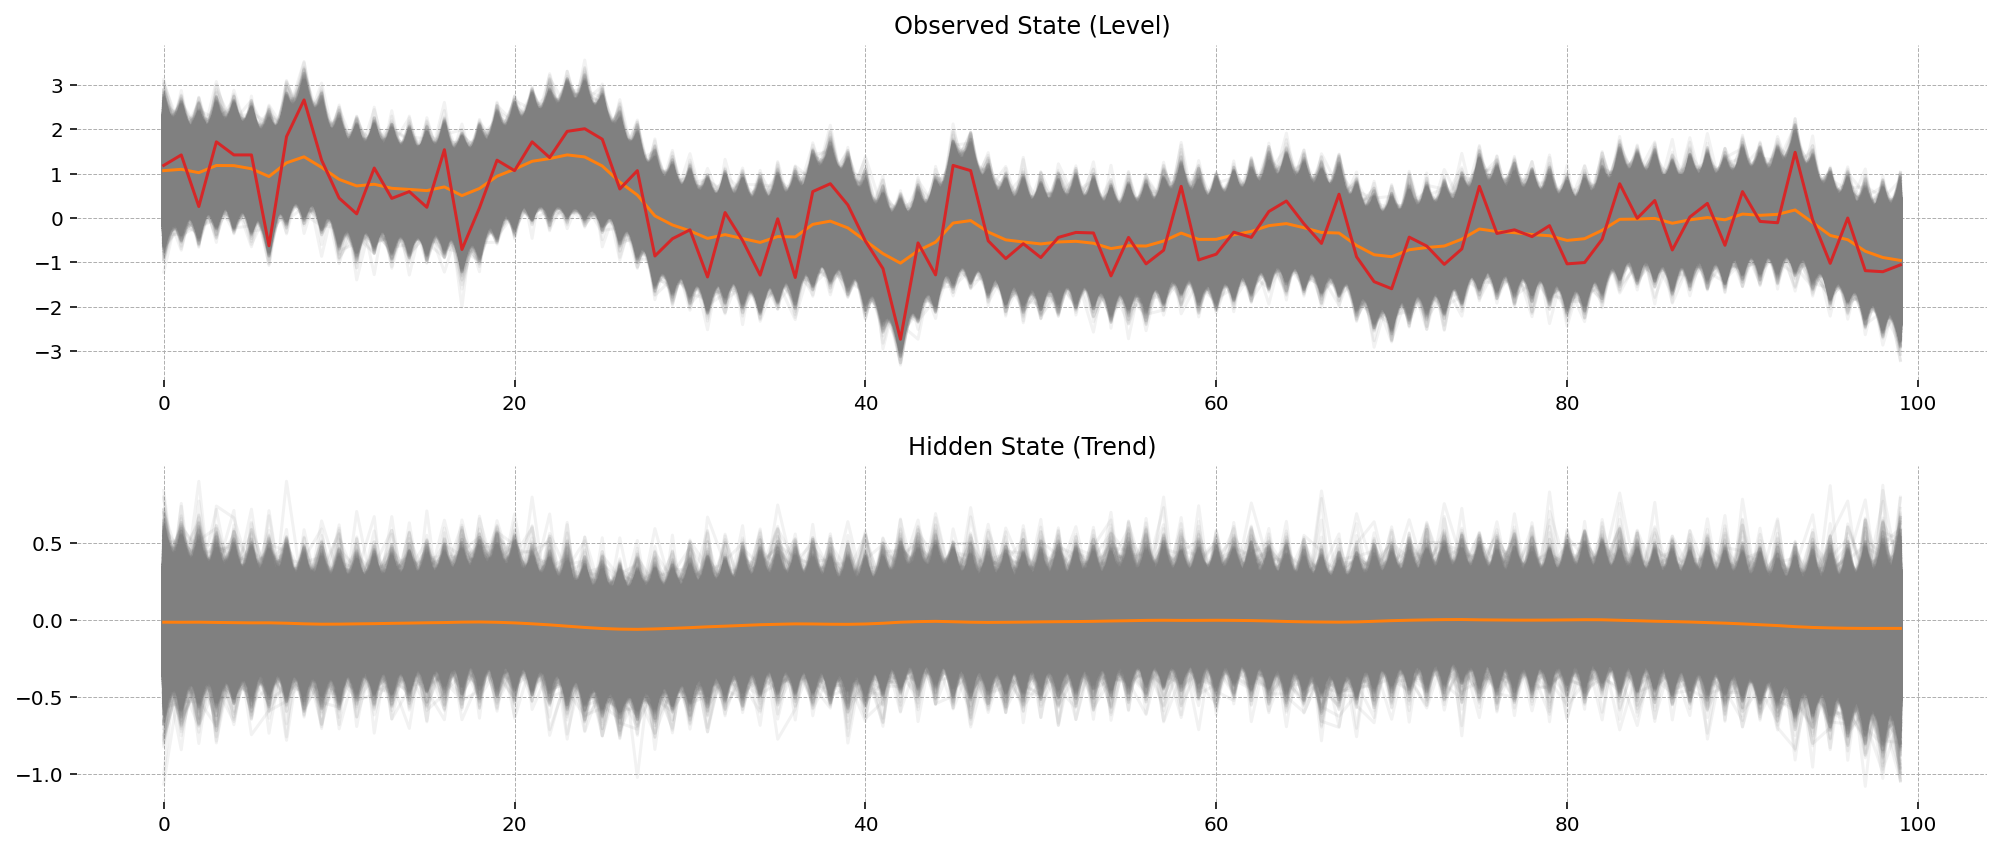

In [35]:
conditional_posterior = state_space_model.sample_conditional_posterior(
    kalman_trace, filter_output="smoothed", posterior_samples=0.25
)

fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(conditional_posterior[:, :, idx].T, color="0.5", alpha=0.1)
    axis.plot(
        conditional_posterior[:, :, idx].mean(axis=0),
        color="tab:orange",
        label="Estimated Mean",
    )
    if idx == 0:
        axis.plot(nile.values, color="tab:red")
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

#### Unconditional Posterior

Unconditional dynamics are still not much to look at, but the "fanning" in the level has reduced a lot. If we put a dogmatic prior that the initial trend state is always zero the might look nicer, or if there were some covariance between the initial trend and level states.

I mean the bottom line is that this isn't exactly a sophisticated model; it is what it is.

In [36]:
with nile_model:
    posterior_state_sims, _ = state_space_model.sample_unconditional_posterior(
        kalman_trace, n_steps=100, n_simulations=10, posterior_samples=1000
    )

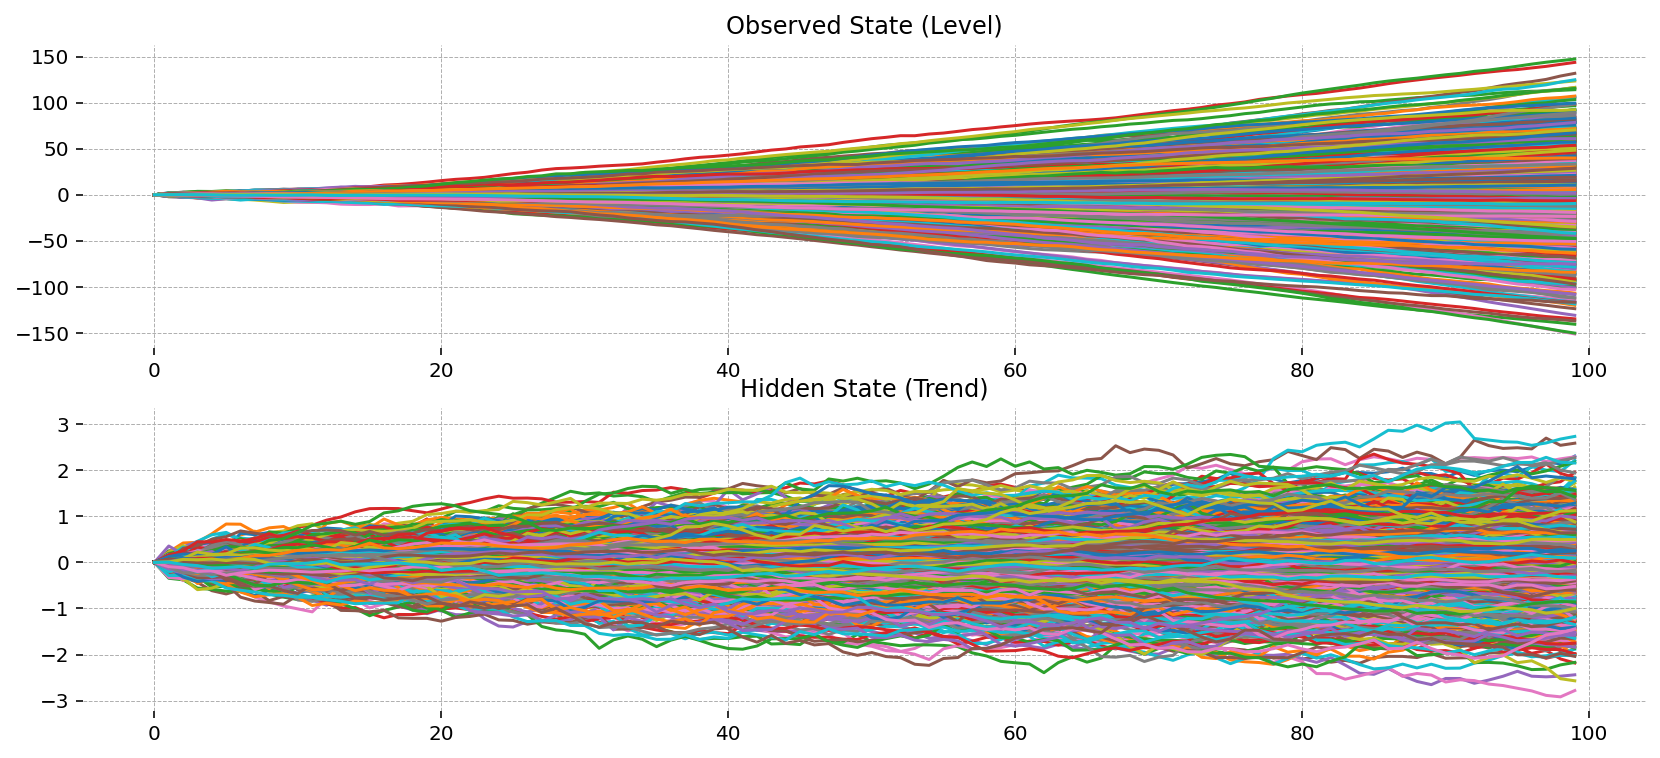

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(posterior_state_sims[:, :, idx].T)
    axis.set(title=name)

## Outputs Compared

In [38]:
az.summary(kalman_trace, var_names=["sigma_state", "sigma_obs", "x0", "P0_diag"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
sigma_state[level]  0.135  0.095   0.000    0.291      0.002    0.002  \
sigma_state[trend]  0.001  0.002   0.000    0.005      0.000    0.000   
sigma_obs           0.476  0.112   0.276    0.693      0.002    0.001   
x0[level]           0.640  0.711  -0.638    2.002      0.011    0.008   
x0[trend]          -0.013  0.618  -1.216    1.088      0.009    0.010   
P0_diag[level]      0.889  1.091   0.097    2.295      0.023    0.017   
P0_diag[trend]      0.872  1.426   0.108    2.132      0.034    0.024   

                    ess_bulk  ess_tail  r_hat  
sigma_state[level]    2932.0    1665.0    1.0  
sigma_state[trend]    3865.0    2319.0    1.0  
sigma_obs             3053.0    2489.0    1.0  
x0[level]             4819.0    2534.0    1.0  
x0[trend]             4575.0    2654.0    1.0  
P0_diag[level]        3852.0    2248.0    1.0  
P0_diag[trend]        2943.0    2174.0    1.0

In [39]:
az.summary(grw_trace, var_names=["sigma_mu", "sigma_obs"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
sigma_mu   0.340  0.099   0.159    0.519      0.008    0.006     145.0  \
sigma_obs  0.694  0.078   0.551    0.845      0.004    0.003     447.0   

           ess_tail  r_hat  
sigma_mu      255.0   1.03  
sigma_obs    1222.0   1.01

In [40]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:             local linear trend   Log Likelihood                -127.011
Date:                Sat, 13 May 2023   AIC                            260.022
Time:                        20:39:52   BIC                            267.777
Sample:                    01-01-1871   HQIC                           263.159
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level         0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend      1.251e-11      0.000   8.51e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.30   Prob(JB):                         0.98
Heteroskedasticity (H):               0.62   Skew:                             0.05
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Smoother Outputs from all 3 models

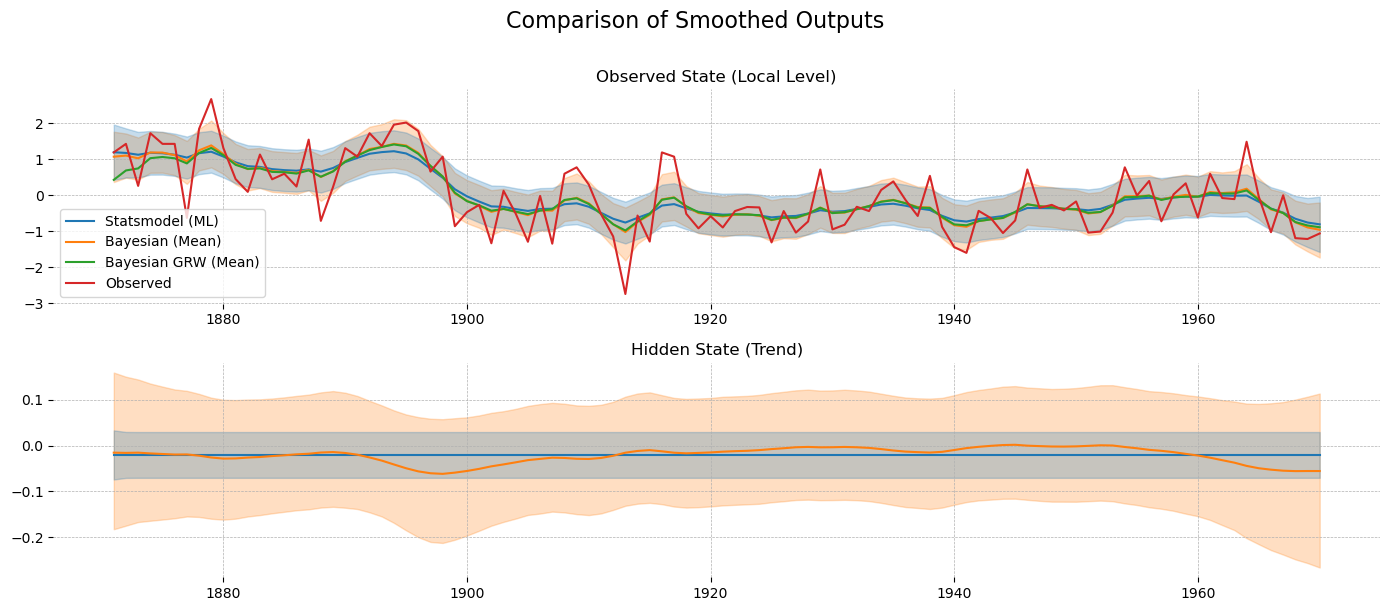

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=100)
x_values = nile.index

mu_pred_long = conditional_posterior.mean(axis=0)
grw_mu

ax[0].plot(nile.index, res.states.smoothed.iloc[:, 0], label="Statsmodel (ML)")
ax[0].plot(nile.index, mu_pred_long[:, 0], label="Bayesian (Mean)")
ax[0].plot(nile.index, grw_mu, label="Bayesian GRW (Mean)")

ax[0].fill_between(
    nile.index,
    np.quantile(conditional_posterior, 0.05, axis=0)[:, 0],
    np.quantile(conditional_posterior, 0.95, axis=0)[:, 0],
    alpha=0.25,
    color="tab:orange",
)

ax[0].fill_between(
    nile.index,
    res.states.smoothed.iloc[:, 0]
    - 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 0, 0]),
    res.states.smoothed.iloc[:, 0]
    + 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 0, 0]),
    alpha=0.25,
    color="tab:blue",
)

ax[0].plot(x_values, nile.values, label="Observed")
ax[0].set(title="Observed State (Local Level)")
ax[0].legend()

ax[1].plot(nile.index, res.states.smoothed.iloc[:, 1], label="Statsmodel (ML)")
ax[1].plot(nile.index, mu_pred_long[:, 1], label="Bayesian (Mean)")
ax[1].fill_between(
    nile.index,
    np.quantile(conditional_posterior, 0.05, axis=0)[:, 1],
    np.quantile(conditional_posterior, 0.95, axis=0)[:, 1],
    alpha=0.25,
    color="tab:orange",
)

ax[1].fill_between(
    nile.index,
    res.states.smoothed.iloc[:, 1]
    - 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 1, 1]),
    res.states.smoothed.iloc[:, 1]
    + 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 1, 1]),
    alpha=0.25,
    color="tab:blue",
)


ax[1].set(title="Hidden State (Trend)")
# ax[1].legend()
fig.suptitle("Comparison of Smoothed Outputs", y=1.01, size=16)
fig.set(facecolor="white")
fig.tight_layout()
plt.show()